Solve the Stokes equation on a square domain.  That is, find $p,\mathbf{v}:\Omega \rightarrow \Re \times \Re^n$ such that
$$
\nabla \cdot \mathbf{v}  = r(x) 
$$
$$
\mathbf{v} + A \nabla p + \nabla \cdot \left(-\epsilon \nabla  \mathbf{v}\right) = 0
$$
on 
$$
\Omega = [0,1]
$$
where $A$ is constant, and $r(x)$ is a function of space only.

In [1]:
from proteus.iproteus import * #pull in what we need for using proteus interactively
Profiling.logLevel=3
Profiling.verbose = True

Define the PDE by defining the coefficients

In [2]:
class MixedPoisson(TransportCoefficients.TC_base):
    """
    The coefficients of the Poisson equation 
    """
    def __init__(self,A,rofx,epsilon=0.001):
        TransportCoefficients.TC_base.__init__(self, 
                         nc=2, #number of components
                         variableNames=['p','v'],
                         advection = {0:{1:'linear'}},#not in equation (would be non-zero for Navier-Stokes)
                         hamiltonian = {1:{0:'linear'}},#A grad (p)
                         diffusion = {1:{1:{1:'constant'}}},#the brinkman term - \epsilon \grad v
                         potential = {1:{1:'u'}}, #define the potential for the diffusion term to be the solution itself
                         reaction  = {0:{0:'constant'},
                                      1:{1:'linear'}})
        self.A=A
        self.rofx=rofx
        self.epsilon=epsilon
        
    def evaluate(self,t,c):
        """
        evaluate quadrature point values held in the dictionary c
        These are labelled according to the 'master equation.' For example,
         
        c[('a',0,0)] = diffusion coefficient for the 0th equation (first) with respect to the
                       0th potential (the solution itself)
                       The value at each quadrature point is a n_d x n_d tensor (n_d=number of space dimensions).
                       Usually the tensor values are stored as a flat array in compressed sparse row format to save space. 
                       By default, we assume the tensor is full though.
                       
        c[('r',0)]   = reaction term for the 0th equation. This is where we will put the source term
        """
        p = c[('u',0)]
        v = c[('u',1)]#1D - x component of velocity
        grad_p = c[('grad(u)',0)]
        #equation 0  div(f) + r = 0  (proteus  notation)  div(velocity)=r(x) (our notation)
        c[('f',0)][...,0] = v
        c[('df',0,1)][...,0] = 1.0  # d_f^0_d_u^0
        c[('r',0)][:]     = -self.rofx(c['x'][:])
        c[('dr',0,0)][:]   = 0.0
        #equation 1   A grad(p) + v + div(-epsilon grad(v)) = 0
        c[('H',1)][:] = self.A[0][0]*grad_p[...,0] #A grad(p)
        c[('dH',1,0)][...,0] = self.A[0][0] #A
        c[('r',1)][:]     = v
        c[('dr',1,1)][:]  = 1.0#1
        c[('a',1,1)][...,0] = self.epsilon# -epsilon \grad v
        c[('da',1,1,1)][...,0] = 0.0# -d_epsilon




Setup the problem to have a solution

$$
p(x_0) = 1 + \sin(2\pi x_0)
$$

or

$$
r(x_0) = 8 \pi^2 \sin(2\pi x_0)
$$

For fun, we can take advantage of sage's symbolic calculus to calculate the correct expression for $r$.

Define the python functions for evaluating the terms. Note that the x array for the quadrature points will be a

multidimensional array. The last dimension will be 3 always though.

In [3]:
#use numpy for evaluations
import numpy as np
a0 = 2.0
def pex0(x):
    pi2=2.0*np.pi    
    return 1.0 + np.sin(pi2*x[...,0])

#note, this is not exact for Stokes
def vex0(x):
    pi2=2.0*np.pi
    return -a0*pi2*np.cos(pi2*x[...,0])

def rofx0(x):
    pi2=2.0*np.pi
    return a0*pi2*pi2*np.sin(pi2*x[...,0])

Define the physical input to the model

In [4]:
#use numpy for evaluations
import numpy as np
physics = default_p
physics.name = "stokes_1d"
physics.nd = 1; #One dimension
#spatial domain
physics.L=(1.0,1.0,1.0)

#the object for evaluating the coefficients   
A  = [[a0]]
epsilon = 1e-5
physics.coefficients=MixedPoisson(A,rofx0,epsilon)

#this functions job is to return another function holding the Dirichlet boundary conditions 
# wherever they are set
    
eps=1.0e-8
boundaryFlags = {'left':1,'right':2,'top':3}
def getDBC_p(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: pex0(x)
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: pex0(x)
    else:
        return None
    
def getNone(x,flag):
    return None

def getZeroFlux(x,flag):
    if x[0] <= 0.0+eps:
        return lambda x,t: 0.0
    elif x[0] >= physics.L[0]-eps:
        return lambda x,t: 0.0
    else:
        return None
    
physics.dirichletConditions = {0:getDBC_p,#pressure Dirichlet
                               1:getNone}

physics.advectiveFluxBoundaryConditions = {0:getNone}#dummy condition for non-existent  advective flux
#there are no diffusion terms in this model, but I had to 
physics.diffusiveFluxBoundaryConditions = {1:{1:getZeroFlux}}#viscous flux
physics.fluxBoundaryConditions = {0:'mixedFlow',1:'outFlow'}

Define the numerics input for the problem

In [13]:
numerics=default_n
#piecewise linears
numerics.femSpaces = {0:FemTools.C0_AffineLinearOnSimplexWithNodalBasis,#pressure space
                      1:FemTools.C0_AffineQuadraticOnSimplexWithNodalBasis}#velocity space
#Quadrature rules for elements and element  boundaries
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,4)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,4)
#number of nodes in the x and y direction
numerics.nn = 101
#numerics.nny= 41
#matrix type
numerics.numericalFluxType = NumericalFlux.StrongDirichletFactory(physics.fluxBoundaryConditions)
#numerics.numericalFluxType = MixedDarcy_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_DiagonalUpwind_Diffusion_IIPG_exterior
#numerics.numericalFluxType = NumericalFlux.Advection_Diagonal_average
numerics.matrix = LinearAlgebraTools.SparseMatrix
#use petsc solvers wrapped by petsc4py
#numerics.multilevelLinearSolver = LinearSolvers.KSP_petsc4py
#numerics.levelLinearSolver = LinearSolvers.KSP_petsc4py
#using petsc4py requires weak boundary condition enforcement
#can also use our internal wrapper for SuperLU
numerics.multilevelLinearSolver = LinearSolvers.LU
numerics.levelLinearSolver = LinearSolvers.LU

#linear solve rtolerance
numerics.l_atol_res = 1.0e-8
numerics.nl_atol_res = 1.0e-4
numerics.periodicDirichletConditions=None
#
# split operator options (trivial since we're not splitting)
#
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = [0,1]

Construct a NumericalSolution object and solve the problem

In [14]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
ns.calculateSolution('run1')
#arrays for using matplotlib's unstructured plotting interface
x = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,0]
#y = ns.modelList[0].levelModelList[-1].mesh.nodeArray[:,1]
#triangles = ns.modelList[0].levelModelList[-1].mesh.elementNodesArray
p = ns.modelList[0].levelModelList[-1].u[0].dof
v = ns.modelList[0].levelModelList[-1].u[1].dof

[      38] Initializing NumericalSolution for stokes_1d
 System includes: 
stokes_1d

[      38] Setting Archiver(s)
[      38] Setting up MultilevelMesh
[      38] Building one multilevel mesh for all models
[      38] Generating mesh for stokes_1d
[      38] Partitioning mesh among 1 processors using partitioningType = 0
[      38] Number of Subdomain Elements Owned= 100
[      38] Number of Subdomain Elements = 100
[      38] Number of Subdomain Nodes Owned= 101
[      38] Number of Subdomain Nodes = 101
[      38] Number of Subdomain elementBoundaries Owned= 101
[      38] Number of Subdomain elementBoundaries = 101
[      38] Number of Subdomain Edges Owned= 100
[      38] Number of Subdomain Edges = 100
[      38] Finished partitioning
[      38] *** Global ***
Number of edges : 100
Number of nodes : 101

*** Local ***
Number of edges : 100
Number of nodes : 101

[      38] Setting up MultilevelTransport for stokes_1d
[      38] Building Transport for each mesh
[      38] Generat

Plot the solution with matplotlib. Only works for $C^0 P^1$ right now

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


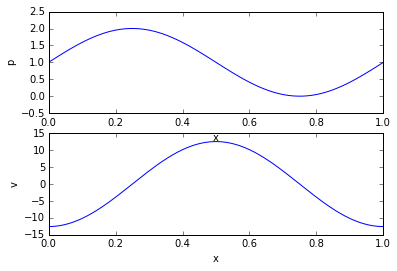

In [16]:
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot(x,p)
ax1.set_xlabel('x')
ax1.set_ylabel('p')
useTH=True
if not useTH:
    ax2.plot(x,v[:numerics.nn])
    ax2.set_xlabel('x')
    ax2.set_ylabel('v')
else:
    xm = np.array(0.5*(x[:-1]+x[1:]))
    xq=[];
    vq=[];
    pq=[];
    for i in range(numerics.nn-1):
        xq.append(x[i])
        vq.append(v[i])
#    uq.append(u[i])
        xq.append(xm[i])
        vq.append(v[numerics.nn+i])
#    uq.append(u[numerics.nn+i])
    xq.append(x[-1])
    vq.append(v[-1])
#uq.append(u[-1])
#xq = np.concatenate([x,xm])
#xq.append(x1[-1])
#ax1.plot(xq,uq)
    ax2.plot(xq,vq)
    ax2.set_xlabel('x')
    ax2.set_ylabel('v')

In [25]:
ptrue = pex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)
ptrue - p

array([  0.00000000e+00,  -4.54523620e-05,  -9.07253443e-05,
        -1.35640275e-04,  -1.80019896e-04,  -2.23689060e-04,
        -2.66475426e-04,  -3.08210135e-04,  -3.48728479e-04,
        -3.87870552e-04,  -4.25481877e-04,  -4.61414019e-04,
        -4.95525170e-04,  -5.27680710e-04,  -5.57753736e-04,
        -5.85625562e-04,  -6.11186192e-04,  -6.34334749e-04,
        -6.54979877e-04,  -6.73040098e-04,  -6.88444138e-04,
        -7.01131203e-04,  -7.11051223e-04,  -7.18165050e-04,
        -7.22444606e-04,  -7.23873004e-04,  -7.22444606e-04,
        -7.18165050e-04,  -7.11051223e-04,  -7.01131203e-04,
        -6.88444138e-04,  -6.73040098e-04,  -6.54979877e-04,
        -6.34334749e-04,  -6.11186192e-04,  -5.85625562e-04,
        -5.57753736e-04,  -5.27680710e-04,  -4.95525170e-04,
        -4.61414019e-04,  -4.25481877e-04,  -3.87870552e-04,
        -3.48728479e-04,  -3.08210135e-04,  -2.66475426e-04,
        -2.23689060e-04,  -1.80019896e-04,  -1.35640275e-04,
        -9.07253443e-05,

Compare to the exact solution, evaluated at the degrees of freedom. Again, only works for $C^0 P^1$ elements

In [26]:
import numpy as np
pex_vals = pex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)
vex_vals = vex0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)
rex_vals = rofx0(ns.modelList[0].levelModelList[-1].mesh.nodeArray)

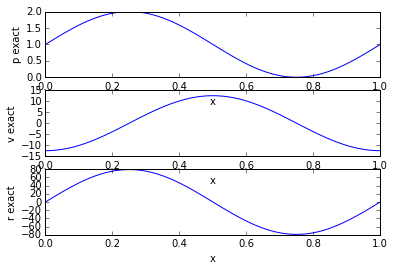

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
ax1.plot(x,pex_vals)
ax1.set_xlabel('x')
ax1.set_ylabel('p exact') 
ax2.plot(x,vex_vals)
ax2.set_xlabel('x')
ax2.set_ylabel('v exact')
ax3.plot(x,rex_vals)
ax3.set_xlabel('x')
ax3.set_ylabel('r exact')

(101,) (100,)
Trapezoidal rule approx for error at dofs for nn=101 is p_l2=0.000509315268591 and v_l2=0.00187408009088 


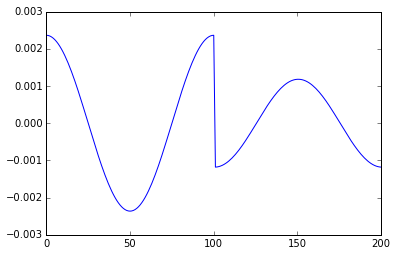

In [29]:
err_p = p-pex_vals
err_p *= err_p
err_p *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_p = np.sqrt(err_p.sum())
print x.shape,xm.shape

vtrue = 0.0*v
for i,val in enumerate(np.concatenate((x,xm))):
    vtrue[i] = vex0(np.array([val]))
err_v = v-vtrue
plt.plot(err_v)
err_v *= err_v
err_v *= physics.L[0]*physics.L[1]/(numerics.nn)
L2approx_v = np.sqrt(err_v.sum())
print "Trapezoidal rule approx for error at dofs for nn=%s is p_l2=%s and v_l2=%s " % (numerics.nn,L2approx_p,L2approx_v)